In [ ]:

! pip install langgraph langchain-community pypdf faiss-cpu sentence-transformers langchain-groq

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:

from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
import os
from langchain_groq import ChatGroq
# # Set up API keys
# os.environ["GROQ_API_KEY"] = "groq_api_key"
def summarize_text(text):
    """Generate a summary using an LLM."""
    prompt = PromptTemplate.from_template(
        """
        Summarize the following text in a concise and clear manner:

        {text}
        """
    )

    llm = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    summary = llm.invoke(prompt.format(text=text))
    return summary.content


def evaluate_summary(original_text, summary):
    """Use an LLM as a judge to evaluate the quality of the summary."""
    prompt = PromptTemplate.from_template(
        """
        Given the original text and its summary, evaluate the summary based on:
        - Relevance: Does it capture the key points?
        - Coherence: Is it logically structured?
        - Fluency: Is the language natural and clear?

        Original Text:
        {original_text}

        Summary:
        {summary}

        Provide a score (1-10) for each criterion and a brief justification.
        """
    )

    llm = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    evaluation = llm.invoke(prompt.format(original_text=original_text, summary=summary))
    return evaluation.content



In [3]:
if __name__ == "__main__":
    text = """Machine learning is a branch of artificial intelligence (AI) that focuses on building systems that learn from and make decisions based on data. It is widely used in various industries, including healthcare, finance, and technology, for applications such as predictive analytics, fraud detection, and natural language processing."""
    print("Generating Summary...")
    summary = summarize_text(text)
    print("Summary:", summary)

    print("\nEvaluating Summary...")
    evaluation = evaluate_summary(text, summary)
    print("Evaluation:", evaluation)

Generating Summary...
Summary: Machine learning is a type of artificial intelligence that enables computers to learn from data and make decisions.  It's used in many fields like healthcare and finance for tasks like predicting outcomes, identifying fraud, and understanding language. 


Evaluating Summary...
Evaluation: Here's an evaluation of the summary:

* **Relevance (9/10):** The summary accurately captures the key points of the original text. It mentions machine learning as a subset of AI, its ability to learn from data and make decisions, and its applications in various industries. 

* **Coherence (8/10):** The summary is logically structured. It starts by defining machine learning, then explains its function, and finally provides examples of its applications. 

* **Fluency (9/10):** The language is natural and clear. The sentences are concise and easy to understand.


**Overall:** The summary is a good representation of the original text. It is concise, accurate, and well-writte

In [4]:

from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
import os
import langgraph
from langgraph.graph import StateGraph
from typing import TypedDict


# Define state schema
class AgentState(TypedDict):
    text: str
    summary: str
    evaluation: str

# Define agent functions
def summarize_text(state: AgentState) -> AgentState:
    """Generate a summary using an LLM."""
    prompt = PromptTemplate.from_template(
        """
        Summarize the following text in a concise and clear manner:

        {text}
        """
    )

    llm = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    summary = llm.invoke(prompt.format(text=state["text"]))
    return {"text": state["text"], "summary": summary.content, "evaluation": ""}


def evaluate_summary(state: AgentState) -> AgentState:
    """Use an LLM as a judge to evaluate the quality of the summary."""
    prompt = PromptTemplate.from_template(
        """
        Given the original text and its summary, evaluate the summary based on:
        - Relevance: Does it capture the key points?
        - Coherence: Is it logically structured?
        - Fluency: Is the language natural and clear?

        Original Text:
        {original_text}

        Summary:
        {summary}

        Provide a score (1-10) for each criterion and a brief justification.
        """
    )

    llm = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    evaluation = llm.invoke(prompt.format(original_text=state["text"], summary=state["summary"]))
    return {"text": state["text"], "summary": state["summary"], "evaluation": evaluation.content}

# Define agent graph
workflow = StateGraph(AgentState)
workflow.add_node("summarize", summarize_text)
workflow.add_node("evaluate", evaluate_summary)

workflow.set_entry_point("summarize")
workflow.add_edge("summarize", "evaluate")

agent = workflow.compile()



In [5]:
# ! pip install pygraphviz pyppeteer
from graphviz import Source
from IPython.display import Image, display

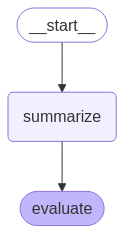

In [7]:
# Visualize the Graph (Optional)
from IPython.display import Image, display
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
if __name__ == "__main__":
    text = """Machine learning is a branch of artificial intelligence (AI) that focuses on building systems that learn from and make decisions based on data. It is widely used in various industries, including healthcare, finance, and technology, for applications such as predictive analytics, fraud detection, and natural language processing."""

    print("Running Agent...")
    result = agent.invoke({"text": text, "summary": "", "evaluation": ""})

    print("\nSummary:", result["summary"])
    print("\nEvaluation:", result["evaluation"])
    # Visualize the Graph (Optional)
# Visualize the Graph (Optional)


Running Agent...

Summary: Machine learning is a type of artificial intelligence that enables computers to learn from data and make decisions.  It's used in many fields like healthcare and finance for tasks like predicting outcomes, identifying fraud, and understanding language. 


Evaluation: Here's an evaluation of the summary:

* **Relevance (9/10):** The summary accurately captures the key points of the original text. It mentions machine learning as a subset of AI, its ability to learn from data and make decisions, and its applications in various industries. 

* **Coherence (8/10):** The summary is logically structured. It starts by defining machine learning, then explains its function, and finally provides examples of its applications. 

* **Fluency (9/10):** The language is natural and clear. The sentences are concise and easy to understand.


**Overall:** The summary is a good representation of the original text. It is concise, accurate, and well-written. 



In [2]:

from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
import os
import langgraph
from langgraph.graph import StateGraph
from typing import TypedDict
from IPython.display import Image, display
from graphviz import Source
import re
from langchain_groq import ChatGroq


# Define state schema
class AgentState(TypedDict):
    text: str
    summary: str
    evaluation: str
    next_step: str
    retries: int

MAX_RETRIES = 3  # Limit the number of retries

# Define agent functions
def summarize_text(state: AgentState) -> AgentState:
    """Generate a summary using an LLM."""
    prompt = PromptTemplate.from_template(
        """
        Summarize the following text in a concise and clear manner:

        {text}
        """
    )

    llm = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    summary = llm.invoke(prompt.format(text=state["text"]))
    return {"text": state["text"], "summary": summary.content, "evaluation": "", "next_step": "", "retries": state["retries"]}


def evaluate_summary(state: AgentState) -> AgentState:
    """Use an LLM as a judge to evaluate the quality of the summary."""
    prompt = PromptTemplate.from_template(
        """
        Given the original text and its summary, evaluate the summary based on:
        - Relevance: Does it capture the key points?
        - Coherence: Is it logically structured?
        - Fluency: Is the language natural and clear?

        Original Text:
        {original_text}

        Summary:
        {summary}

        Provide a score (1-10) for each criterion and a brief justification.
        """
    )

    llm = ChatGroq(temperature=0, model_name="gemma2-9b-it")
    evaluation = llm.invoke(prompt.format(original_text=state["text"], summary=state["summary"]))
    return {"text": state["text"], "summary": state["summary"], "evaluation": evaluation.content, "next_step": "", "retries": state["retries"]}


def decide_next_step(state: AgentState) -> AgentState:
    """Check evaluation scores and decide whether to retry or finish."""
    evaluation_text = state["evaluation"]
    scores = {
        "relevance": 0,
        "coherence": 0,
        "fluency": 0,
    }

    # Extract numerical scores using regex
    matches = re.findall(r"(Relevance|Coherence|Fluency):\s*(\d+)", evaluation_text, re.IGNORECASE)
    for category, score in matches:
        scores[category.lower()] = int(score)

    # If any score is below 7 and retries are left, retry summarization
    if any(score < 7 for score in scores.values()) and state["retries"] < MAX_RETRIES:
        next_step = "summarize"
        retries = state["retries"] + 1
    else:
        next_step = "terminate"
        retries = state["retries"]

    return {"text": state["text"], "summary": state["summary"], "evaluation": state["evaluation"], "next_step": next_step, "retries": retries}


def terminate_process(state: AgentState) -> AgentState:
    """Final termination state."""
    return state

# Define agent graph
workflow = StateGraph(AgentState)
workflow.add_node("summarize", summarize_text)
workflow.add_node("evaluate", evaluate_summary)
workflow.add_node("decide", decide_next_step)
workflow.add_node("terminate", terminate_process)

workflow.set_entry_point("summarize")
workflow.add_edge("summarize", "evaluate")
workflow.add_edge("evaluate", "decide")
workflow.add_conditional_edges("decide", lambda state: state["next_step"], {"summarize": "summarize", "terminate": "terminate"})

agent = workflow.compile()



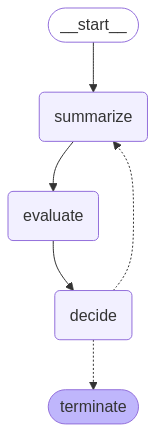

In [3]:
# Visualize the Graph (Optional)
from IPython.display import Image, display
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [5]:
if __name__ == "__main__":
    text = """Machine learning is a branch of artificial intelligence (AI) that focuses on building systems that learn from and make decisions based on data. It is widely used in various industries, including healthcare, finance, and technology, for applications such as predictive analytics, fraud detection, and natural language processing."""

    print("Running Agent...")
    result = agent.invoke({"text": text, "summary": "", "evaluation": "", "next_step": "", "retries": 0})

    print("\nSummary:", result["summary"])
    print("\nEvaluation:", result["evaluation"])


Running Agent...

Summary: Machine learning is a type of artificial intelligence that enables computers to learn from data and make decisions.  It's used in many fields like healthcare and finance for tasks like predicting outcomes, identifying fraud, and understanding language. 


Evaluation: Here's an evaluation of the summary:

* **Relevance (9/10):** The summary accurately captures the key points of the original text. It mentions machine learning as a subset of AI, its ability to learn from data and make decisions, and its applications in various industries. 

* **Coherence (8/10):** The summary is logically structured. It starts by defining machine learning, then explains its function, and finally provides examples of its applications. 

* **Fluency (9/10):** The language is natural and clear. The sentences are concise and easy to understand.


**Overall:** The summary is a good representation of the original text. It is concise, accurate, and well-written. 

